In [1]:
%load_ext autoreload
%autoreload 2

#Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sympy import symbols, diff, lambdify
from scipy.optimize import minimize

#Py files
import multijoueurs_Q as multiQ
import resultsPriceandProfits as res 

In [2]:
import numpy as np
 # Changer le nombre de joueurs ici

aggregated_agents = []
for price in [[1,2],[None,None]]:
    total_rewards = []

    for loop in range(3):
        print("Loop:", loop)
        agents = [multiQ.Agent(pN=price[0],pC=price[1]) for _ in range(2)]
        env = multiQ.Env()

        temps = []
        rewards = []
        epsilon = []
        prices = []

        # Initialisation des prix p0 (on va le faire directement dans chaque agent)
        for agent in agents:
            agent.p = np.random.choice(agent.A)

        # Initialisation de l'état
        s_t = env([agent.p for agent in agents])[1]
        for agent in agents:
            agent.s_t = s_t

        s_ind = agents[0].find_index(agents[0].S, agents[0].s_t)
        for agent in agents:
            agent.s_ind = s_ind

        # Phase itérative
        for t in range(10**6):
            # Actions et état t+1
            for agent in agents:
                agent.a_ind = agent.get_next_action()

            s_t1 = env([agent.A[agent.a_ind] for agent in agents])[1]
            for agent in agents:
                agent.s_t1 = s_t1

            s_ind1 = agents[0].find_index(agents[0].S, agents[0].s_t1)
            for agent in agents:
                agent.s_ind1 = s_ind1

            temps.append(t)
            ret = env(s_t1)
            quant, price, cost = ret

            re = ret[0]*ret[1]-ret[0]*ret[2]
            rewards.append(re)
            epsilon_values = [agent.epsilon for agent in agents]
            epsilon.append(epsilon_values)
            prices.append([agent.p for agent in agents])

            for i, agent in enumerate(agents):
                agent.updateQ(q=quant[i], p=price[i], c=cost[i], t=t)

        total_rewards.append(rewards)

    aggregated_agents.append(np.array(total_rewards).mean(axis=0))

Loop: 0
Loop: 1
Loop: 2
Loop: 0
Loop: 1
Loop: 2


In [3]:
aggregated_agents

[array([[0.21352994, 0.17097574],
        [0.22192036, 0.24237704],
        [0.1670842 , 0.21101276],
        ...,
        [0.29595741, 0.29595741],
        [0.31043114, 0.28784489],
        [0.29595741, 0.29595741]]),
 array([[0.34624664, 0.25668564],
        [0.32805274, 0.34045856],
        [0.26017051, 0.34408182],
        ...,
        [0.33380086, 0.33380086],
        [0.33380086, 0.33380086],
        [0.33380086, 0.33380086]])]

In [18]:
aggregated_agents[0][-100:,0].mean()

0.30319427864898046

/var/folders/1v/lw80nwsd61d7sp0q_pzj0ppm0000gp/T/ipykernel_1809/1383625553.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/Suzie/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


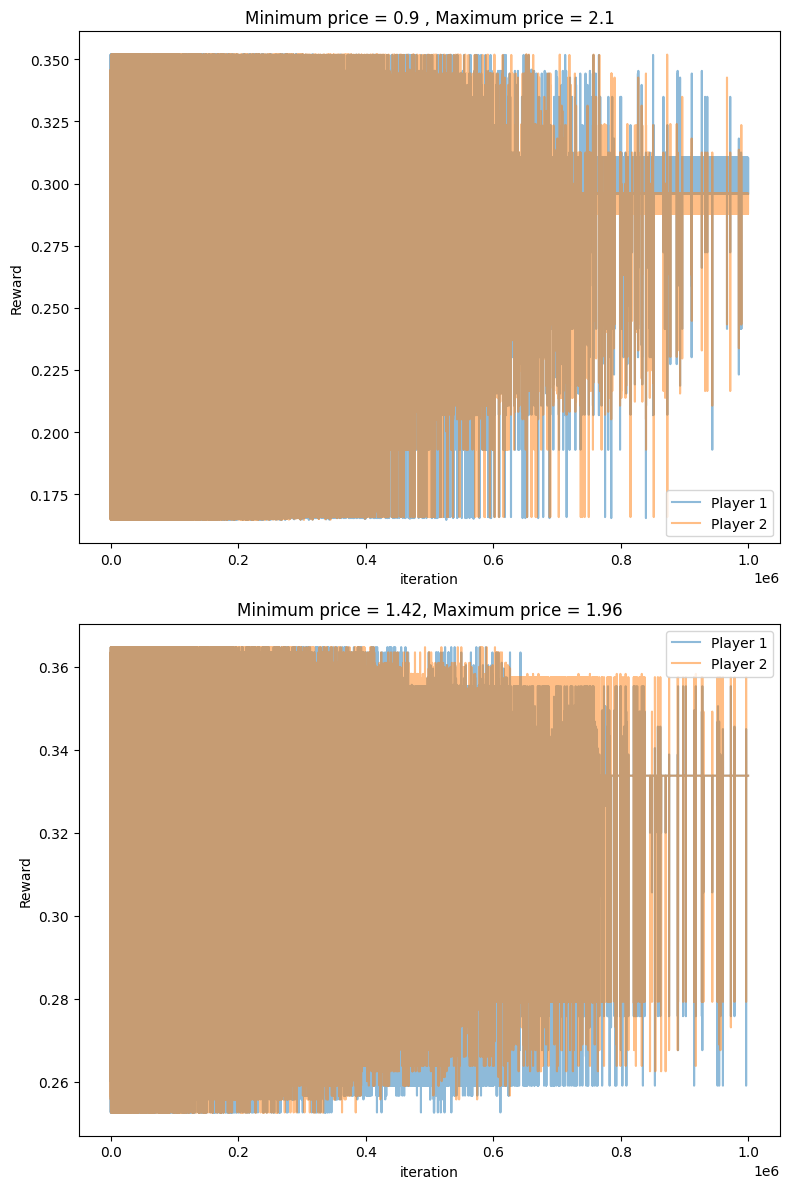

In [4]:
import matplotlib.pyplot as plt
import numpy as np


num_graphs = len(aggregated_agents)
smart_label = ["Minimum price = 0.9 , Maximum price = 2.1", "Minimum price = 1.42, Maximum price = 1.96"]

# Créer une figure avec autant de sous-graphiques que de périodes
fig, axes = plt.subplots(nrows=num_graphs, figsize=(8, 12))

# Boucle pour itérer à travers les périodes et les sous-graphiques
for graphs in range(num_graphs):
    ax = axes[graphs]
    num_players = len(aggregated_agents[graphs][0])
    # Tracer les courbes pour chaque joueur dans le sous-graphique
    for player in range(num_players):
        ax.plot(aggregated_agents[graphs][:, player], alpha=0.5, label=f'Player {player+1}')
    
    # Titre du sous-graphique avec la période correspondante
    ax.set_title(f'{smart_label[graphs]}')
    
    # Ajouter une légende pour chaque sous-graphique
    ax.legend()
    
    # Nommer les axes du sous-graphique
    ax.set_xlabel('iteration')
    ax.set_ylabel('Reward')

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher la figure
plt.show()

In [26]:
prices = res.PriceOptimizer(nb_players=2)
collusion_profit, collusion_prices = prices.CollusionPrice()
nash_profit, nash_prices = prices.NashPrice()
RN = nash_profit
RC = collusion_profit
    
Rmean = np.zeros((len(aggregated_agents), 2))
DRmean = np.zeros((len(aggregated_agents), 2))   
    
for i in range (len(aggregated_agents)): 
    for j in range (2):
        Rmean[i][j] = aggregated_agents[i][-100:,j].mean()
        DRmean[i][j] = (Rmean[i][j] - RN)/(RC - RN) 

print(RN, RC)
print(Rmean)
print(DRmean)

av = np.mean(DRmean, axis=1)
print(av)

print("Mean $\\Delta$ for prices 0.9-2.1:", av[0])
print("Mean $\\Delta$ for prices 1.42-1.96:", av[1])

0.2216948057185367 0.33749024551469464
[[0.30319428 0.29190115]
 [0.33380086 0.33380086]]
[[0.70382282 0.60629631]
 [0.96813879 0.96813879]]
[0.65505956 0.96813879]
Mean $\Delta$ for prices 0.9-2.1: 0.6550595631889709
Mean $\Delta$ for prices 1.42-1.96: 0.9681387940070145
